In [1]:
import numpy as np
import os
arr_blocks = np.loadtxt('..\\sample_scores.txt', delimiter=',')
arr_flat = arr_blocks.reshape(-1)
arr_idx = np.arange(arr_flat.shape[0])

In [2]:
eps = 0.501
def linear_quant(arr: np.ndarray, n):
    minval = arr.min()
    maxval = arr.max()
    arr = (arr - minval) / (maxval - minval)
    q_arr = np.round(arr * (2**n-eps))
    return q_arr, (minval, maxval)

def linear_dequant(q_arr: np.ndarray, params, n):
    minval, maxval = params
    arr = q_arr / (2**n-eps)
    arr = minval + arr * (maxval - minval)
    return arr

def log_quant(arr: np.ndarray, n):
    n -= 1
    pos_mask = arr > 0
    neg_mask = arr < 0
    arr = np.log2(np.abs(arr))

    minexp = arr[pos_mask].min()
    maxexp = arr[pos_mask].max()
    neg_minexp = arr[neg_mask].min()
    neg_maxexp = arr[neg_mask].max()
    
    arr[pos_mask] = (arr[pos_mask] - minexp) / (maxexp - minexp)
    arr[neg_mask] = (arr[neg_mask] - neg_minexp) / (neg_maxexp - neg_minexp)
    q_arr = np.zeros(arr.shape[0], dtype=int)
    q_arr[pos_mask] = np.round(arr[pos_mask] * (2**n-eps)) + 2**n
    q_arr[neg_mask] = np.round(arr[neg_mask] * (2**n-1-eps)) + 1
    return q_arr, (minexp, maxexp, neg_minexp, neg_maxexp)

def log_dequant(q_arr: np.ndarray, params, n):
    n -= 1
    minexp, maxexp, neg_minexp, neg_maxexp = params
    pos_mask = q_arr >= 2**n
    neg_mask = (q_arr >= 1) & (q_arr < 2**n)
    q_arr[pos_mask] -= 2**n
    q_arr[neg_mask] -= 1
    arr = np.zeros(q_arr.shape[0], dtype=float)
    arr[pos_mask] = q_arr[pos_mask] / (2**n-eps)
    arr[neg_mask] = q_arr[neg_mask] / (2**n-1-eps)
    
    arr[pos_mask] = minexp + arr[pos_mask] * (maxexp - minexp)
    arr[neg_mask] = neg_minexp + arr[neg_mask] * (neg_maxexp - neg_minexp)
    arr[pos_mask] = 2**arr[pos_mask]
    arr[neg_mask] = -2**arr[neg_mask]
    return arr

In [3]:
def quantize_mant(sign, abs_mant, n_mant):
    # mant: [0.5, 1.0) -> [0.0, 1.0)
    abs_mant = 2*abs_mant-1
    q_mant = np.zeros(abs_mant.shape[0], dtype=int)
    # q_mant: [2**m, 2**(m+1)-1]
    q_mant[sign > 0] = np.round(abs_mant[sign > 0] * (2**n_mant-eps)) + 2**n_mant
    # q_mant: [1, 2**m-1]
    q_mant[sign < 0] = np.round(abs_mant[sign < 0] * (2**n_mant-1-eps)) + 1
    return q_mant

def dequantize_mant(q_mant, n_mant):
    pos_mask = q_mant >= 2**n_mant
    neg_mask = (q_mant >= 1) & (q_mant < 2**n_mant)
    q_mant[pos_mask] -= 2**n_mant
    q_mant[neg_mask] -= 1
    mant = np.zeros(q_mant.shape[0], dtype=float)
    mant[pos_mask] = q_mant[pos_mask] / (2**n_mant-eps)
    mant[neg_mask] = q_mant[neg_mask] / (2**n_mant-1-eps)
    mant[pos_mask | neg_mask] = 0.5 * (mant[pos_mask | neg_mask] + 1)
    return mant


def adaptivfloat(arr, n_bits=8, n_exp=4):
    n_mant = n_bits-1-n_exp

    # 1. store sign value and do the following part as unsigned value
    sign = np.sign(arr)
    arr = np.abs(arr)

    # 1.5  if bias not determined, auto set exponent bias by the maximum input 
    exp_max = np.frexp(arr.max())[1]-1
    exp_bias = exp_max - (2**n_exp - 1)

    ## min and max values of adaptivfloat
    value_min = 2.0**exp_bias*(1+2.0**(-n_mant))
    value_max = (2.0**exp_max)*(2.0-2.0**(-n_mant))
    
    ## 2.1. reduce too small values to zero
    arr[arr < 0.5*value_min] = 0
    arr[(arr > 0.5*value_min) & (arr < value_min)] = value_min

    ## 2.2. reduce too large values to max value of output format
    arr[arr > value_max] = value_max

    # 3. get mant, exp (the format is different from IEEE float)
    mant, exp = np.frexp(arr)
    q_mant = quantize_mant(sign, mant, n_mant)
    mant = dequantize_mant(q_mant, n_mant)
    return sign * mant * 2.0**exp

In [4]:
q_arr, params = linear_quant(arr_flat, 8)
arr_linear = linear_dequant(q_arr, params, 8)

In [5]:
q_arr, params = log_quant(arr_flat, 8)
arr_log = log_dequant(q_arr, params, 8)

In [6]:
arr_adapt = np.apply_along_axis(adaptivfloat, 1, arr_blocks).reshape(-1)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

sample_mask = np.random.choice([True, False], arr_idx.shape[0], p=[0.05, 0.95])

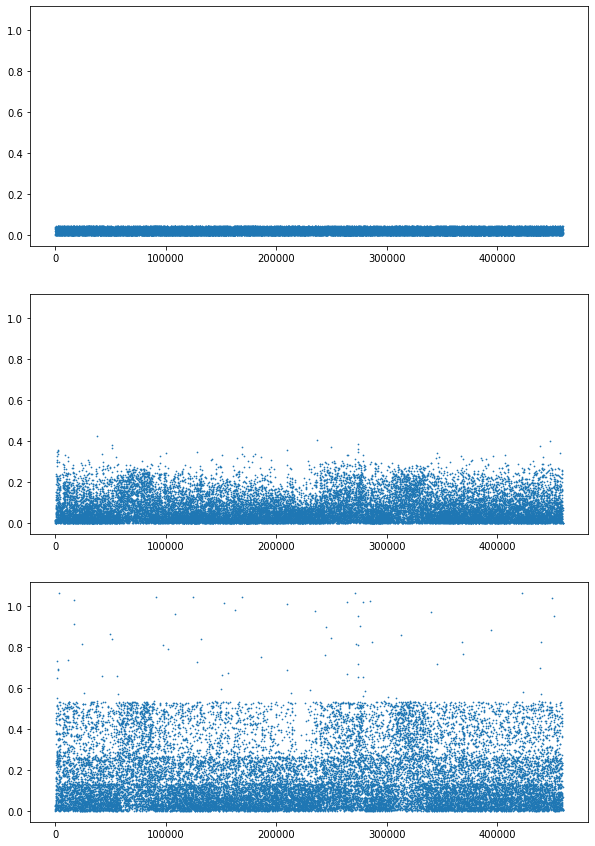

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10,15), sharey=True)

ax[0].scatter(arr_idx[sample_mask], np.abs(arr_flat[sample_mask] - arr_linear[sample_mask]), s=0.5)
ax[1].scatter(arr_idx[sample_mask], np.abs(arr_flat[sample_mask] - arr_log[sample_mask]), s=0.5)
ax[2].scatter(arr_idx[sample_mask], np.abs(arr_flat[sample_mask] - arr_adapt[sample_mask]), s=0.5)